<a href="https://colab.research.google.com/github/yiranlus/Ankia-Theme/blob/main/12.%20Machine%20Learning/ML1%20-%20Intro/MachineLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project on Arbres

## * Fetching the Data

In [1]:
# @title Download the Arbres Dataset
!curl -L "https://data.metropolegrenoble.fr/d4c/api/records/2.0/downloadfile/format=csv&resource_id=17fff084-3e54-4add-8d00-e2d31676fdec&use_labels_for_header=true&user_defined_fields=true" -o arbres_grenoble_epsg4326.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8789k  100 8789k    0     0  1070k      0  0:00:08  0:00:08 --:--:-- 2329k


In [2]:
# Alternatively, we can use pure Python
# import urllib

# DOWNLOAD_URL = "https://data.metropolegrenoble.fr/d4c/api/records/2.0/downloadfile/format=csv&resource_id=17fff084-3e54-4add-8d00-e2d31676fdec&use_labels_for_header=true&user_defined_fields=true"
# DOWNLOAD_PATH = "./arbres_grenoble_epsg4326.csv"

# def fetch_arbre_data(url=DOWNLOAD_URL, path=DOWNLOAD_PATH):
#     urllib.request.urlretrieve(url, path)

# fetch_arbre_data()

In [3]:
# @title Verify the Download
!head {DOWNLOAD_PATH}

﻿elem_point_id,code,nom,genre,genre_desc,categorie,categorie_desc,sous_categorie,sous_categorie_desc,code_parent,code_parent_desc,adr_secteur,bien_reference,genre_bota,espece,variete,stadededeveloppement,equipe,remarques,anneedeplantation,raisondeplantation,traitementchenilles,courrier,identifiantplu,typeimplantationplu,intituleprotectionplu,anneeabattage,essouchement,diametrearbre,causeabattage,collectivite,stationmetro,hauteurarbre,portarbre,structure,forme,typenature,geo_point_2d
34835,ESP36318,AR36318,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,AR36318,Prunus,serrulata,,Arbre jeune,,,2015,Nouveau,,,,,,,,,,Grenoble Alpes Métropole,,,,Métropole de Grenoble,,,"45.167098421885385,5.740131798404362"
34836,ESP36319,AR36319,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,AR36319,Prunus,serrulata,,Arbre jeune,,,2015,Nouveau,,,,,,,,,,Grenoble Alpes Métropole,,,,Métropole de Grenoble,,,"45.16710682038838,

## Import the Essential Modules

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import missingno as msno

import folium
from folium.plugins import FastMarkerCluster

try:
    from google.colab import data_table

    # Enable interactive table display
    data_table.enable_dataframe_formatter()
    from google.colab.data_table import DataTable
except:
    def DataTable(df, *args, **kwargs):
        display(df)


## * Load and Clean the Dataset

In [5]:
df = pd.read_csv("./arbres_grenoble_epsg4326.csv")
df.set_index("elem_point_id", inplace=True)
df["anneedeplantation"] = df["anneedeplantation"].astype(pd.Int64Dtype())
df_latlng = df["geo_point_2d"].str.split(",")
df["latitude"] = pd.to_numeric(df_latlng.apply(lambda x: x[0]))
df["longitude"] = pd.to_numeric(df_latlng.apply(lambda x: x[1]))

category_columns = [
    "genre_bota", "espece", "variete", "stadededeveloppement",
    "raisondeplantation", "traitementchenilles", "typeimplantationplu",
    "stationmetro", "hauteurarbre", "portarbre", "forme", "typenature"
]
for column in category_columns:
    df[column] = df[column].astype("category")

df.drop(columns="geo_point_2d", inplace=True)
DataTable(df.head(), max_columns=len(df.columns))

,code,nom,genre,genre_desc,categorie,categorie_desc,sous_categorie,sous_categorie_desc,code_parent,code_parent_desc,...,causeabattage,collectivite,stationmetro,hauteurarbre,portarbre,structure,forme,typenature,latitude,longitude
elem_point_id,,,,,,,,,,,,,,,,,,,,,
34835,ESP36318,AR36318,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167098,5.740132
34836,ESP36319,AR36319,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167107,5.740200
34837,ESP36320,AR36320,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167115,5.740266
34838,ESP36321,AR36321,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167127,5.740349
34839,ESP36322,AR36322,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167144,5.740471


<Axes: >

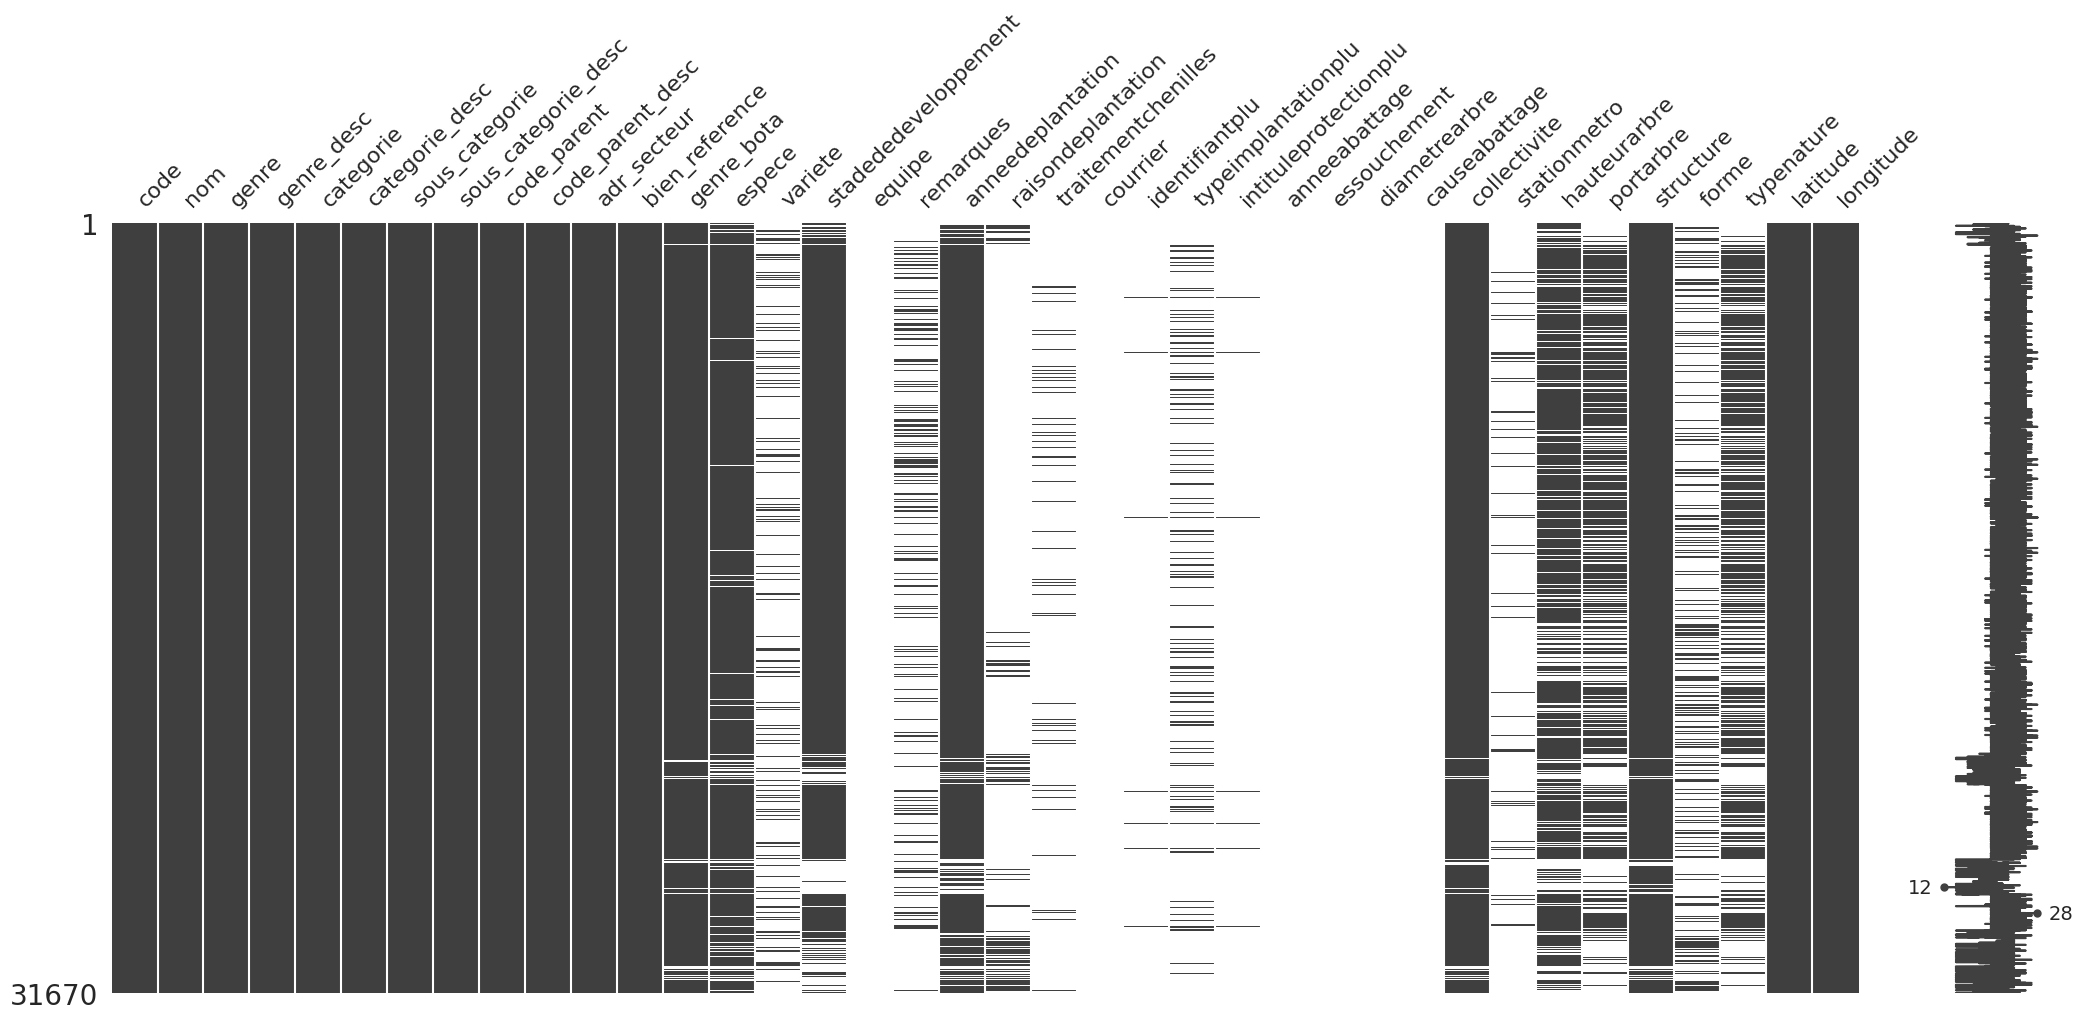

In [6]:
# @title Visualizing the Missing Values
msno.matrix(df)

In [7]:
# @title [Deleted] Remove Trees where "Année de Plantation" is missing

df_clean = df
# df_clean = df_clean.dropna(subset=["anneedeplantation"])

In [8]:
# @title Remove Unhelpful Columns

## All the rows have the same value
df_clean = df_clean.drop(columns=["genre", "genre_desc", "categorie", "categorie_desc"])

## All the rows have missing value
df_clean = df_clean.drop(columns=["equipe", "courrier", "anneeabattage", "essouchement", "diametrearbre", "causeabattage"])

## The identifier
df_clean = df_clean.drop(columns=["code", "nom", "bien_reference"])

DataTable(df_clean.head(), max_columns=len(df_clean.columns))


,sous_categorie,sous_categorie_desc,code_parent,code_parent_desc,adr_secteur,genre_bota,espece,variete,stadededeveloppement,remarques,...,intituleprotectionplu,collectivite,stationmetro,hauteurarbre,portarbre,structure,forme,typenature,latitude,longitude
elem_point_id,,,,,,,,,,,,,,,,,,,,,
34835,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167098,5.740132
34836,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167107,5.740200
34837,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167115,5.740266
34838,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167127,5.740349
34839,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167144,5.740471


In [9]:
# @title Save to Pickle
df_clean.to_pickle("arbres_grenoble_epsg4326_clean.pickle")

print("Saved to picle arbres_grenoble_epsg4326_clean.pickle")

Saved to picle arbres_grenoble_epsg4326_clean.pickle


## Load the Cleaned Dataset

In [10]:
df_clean = pd.read_pickle("arbres_grenoble_epsg4326_clean.pickle")

## A Glance on the Dataset

In [11]:
DataTable(df_clean.head())

,sous_categorie,sous_categorie_desc,code_parent,code_parent_desc,adr_secteur,genre_bota,espece,variete,stadededeveloppement,remarques,...,intituleprotectionplu,collectivite,stationmetro,hauteurarbre,portarbre,structure,forme,typenature,latitude,longitude
elem_point_id,,,,,,,,,,,,,,,,,,,,,
34835,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167098,5.740132
34836,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167107,5.740200
34837,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167115,5.740266
34838,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167127,5.740349
34839,ESP151,Arbre de voirie,ESP237,Av La Bruyère Helbronner au Sq,5,Prunus,serrulata,NaN,Arbre jeune,NaN,...,NaN,Grenoble Alpes Métropole,NaN,NaN,NaN,Métropole de Grenoble,NaN,NaN,45.167144,5.740471


In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31670 entries, 34835 to 44982
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sous_categorie         31670 non-null  object  
 1   sous_categorie_desc    31670 non-null  object  
 2   code_parent            31670 non-null  object  
 3   code_parent_desc       31670 non-null  object  
 4   adr_secteur            31670 non-null  int64   
 5   genre_bota             30859 non-null  category
 6   espece                 29370 non-null  category
 7   variete                4599 non-null   category
 8   stadededeveloppement   27496 non-null  category
 9   remarques              5312 non-null   object  
 10  anneedeplantation      29526 non-null  Int64   
 11  raisondeplantation     3287 non-null   category
 12  traitementchenilles    2066 non-null   category
 13  identifiantplu         587 non-null    float64 
 14  typeimplantationplu    4968 non-null   

In [13]:
df_clean.describe()

,adr_secteur,anneedeplantation,identifiantplu,latitude,longitude
count,31670.000000,29526.0,587.000000,31669.000000,31669.000000
mean,469.145216,1990.445099,88.039182,45.177284,5.727465
std,4194.774114,18.174352,60.858395,0.012202,0.013103
min,1.000000,1900.0,2.000000,45.151707,5.695268
25%,2.000000,1975.0,67.000000,45.166146,5.717468
50%,4.000000,1987.0,70.000000,45.175837,5.729637
75%,5.000000,2006.0,70.000000,45.187428,5.737486
max,38421.000000,2024.0,358.000000,45.224825,5.798704


In [14]:
for column in df_clean.columns:
    if column.endswith("_desc"):
        continue
    print(column, ":", df_clean[column].unique().tolist())

sous_categorie : ['ESP151', 'ESP174', 'ESP065', 'ESP187']
code_parent : ['ESP237', 'ESP395', 'ESP1166', 'ESP759', 'ESP273', 'ESP99', 'ESP1413', 'ESP470', 'ESP217', 'ESP384', 'ESP356', 'ESP42911', 'ESP25', 'ESP643', 'ESP906', 'ESP713', 'ESP382', 'ESP1301', 'ESP1303', 'ESP805', 'ESP522', 'ESP340', 'ESP32989', 'ESP1156', 'ESP125', 'ESP380', 'ESP1012', 'ESP119', 'ESP198', 'ESP278', 'ESP277', 'ESP1180', 'ESP487', 'ESP1132', 'ESP176', 'ESP647', 'ESP146', 'ESP318', 'ESP85', 'ESP211', 'ESP37895', 'ESP398', 'ESP1377', 'ESP363', 'ESP977', 'ESP14', 'ESP40109', 'ESP168', 'ESP613', 'ESP52', 'ESP611', 'ESP42909', 'ESP963', 'ESP574', 'ESP570', 'ESP195', 'ESP936', 'ESP804', 'ESP989', 'ESP680', 'ESP738', 'ESP155', 'ESP1274', 'ESP798', 'ESP878', 'ESP386', 'ESP747', 'ESP1407', 'ESP40238', 'ESP915', 'ESP1234', 'ESP468', 'ESP600', 'ESP374', 'ESP1313', 'ESP432', 'ESP1414', 'ESP40268', 'ESP944', 'ESP260', 'ESP29', 'ESP243', 'ESP1230', 'ESP912', 'ESP732', 'ESP543', 'ESP1121', 'ESP707', 'ESP844', 'ESP1052', 'E

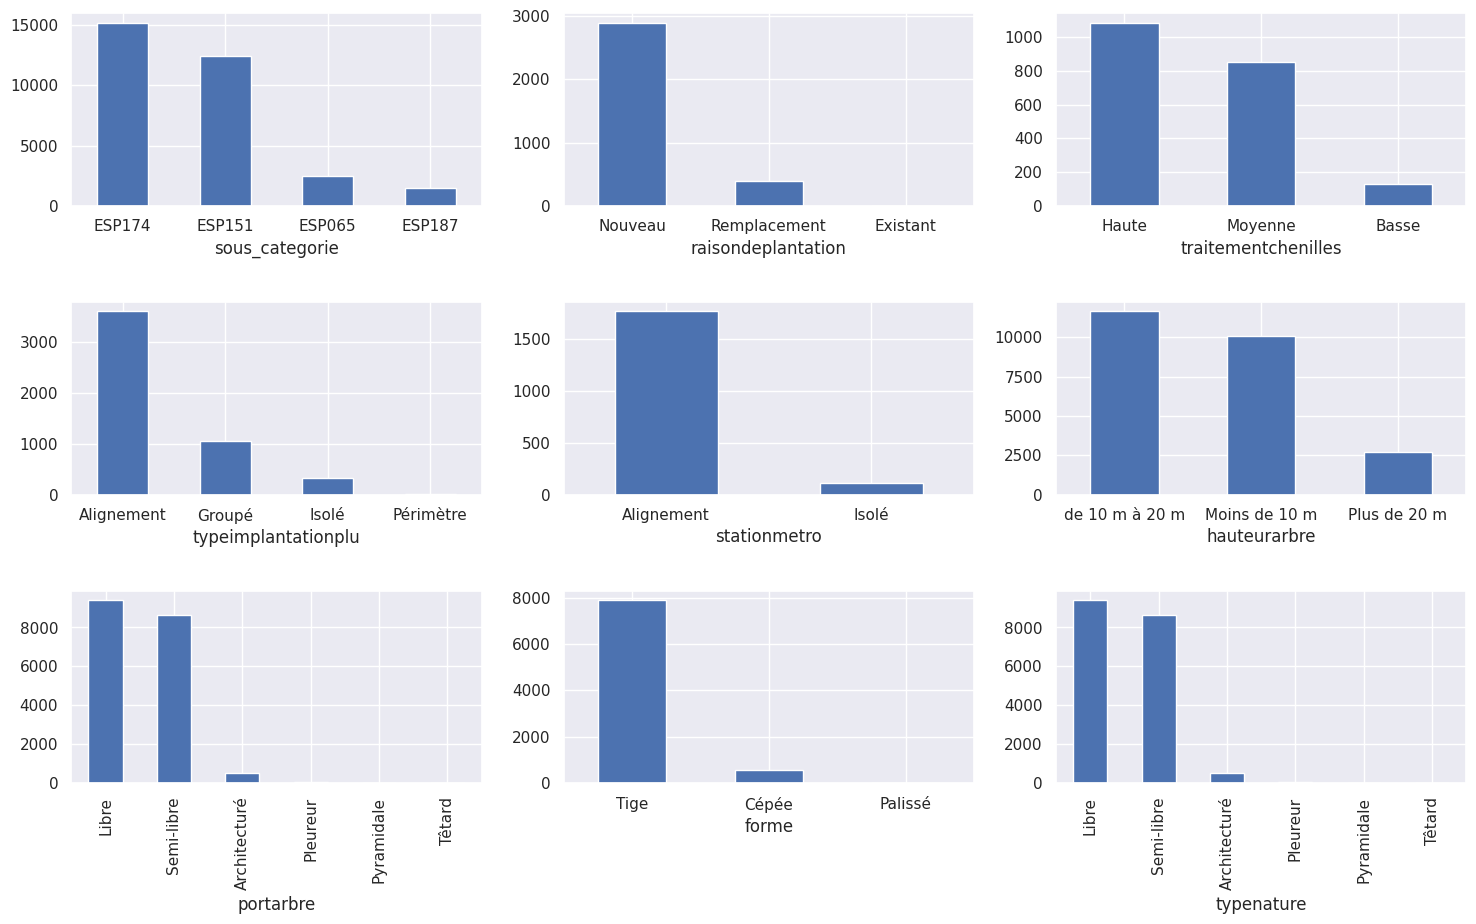

In [15]:
# @title Some Variables
columns = [
    "sous_categorie", "raisondeplantation", "traitementchenilles",
    "typeimplantationplu", "stationmetro", "hauteurarbre", "portarbre",
    "forme", "typenature"
]
does_not_change_rotation = ["portarbre", "typenature"]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 10))
_axs = axs.flatten()

for i, column in enumerate(columns):
    df_clean[column].value_counts().plot.bar(ax=_axs[i])
    # _axs[i].set_title(column)
    if column not in does_not_change_rotation:
        _axs[i].set_xticklabels(labels=_axs[i].get_xticklabels(), rotation=0)

fig.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

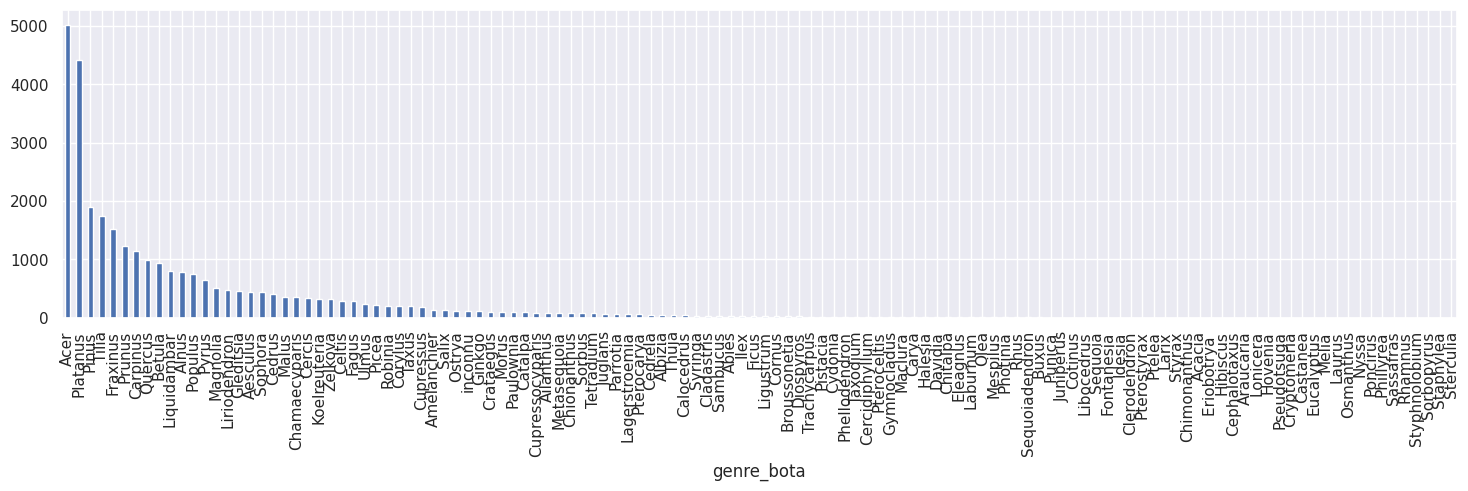

In [16]:
# @title `genre_bota`
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot()

df_genre_bota = df_clean.genre_bota.value_counts()
show_first_n = 40
_df = df_genre_bota[:show_first_n]
_df.loc["others"] = df_genre_bota[show_first_n:].sum()

df_genre_bota.plot.bar(ax=ax)

plt.show()

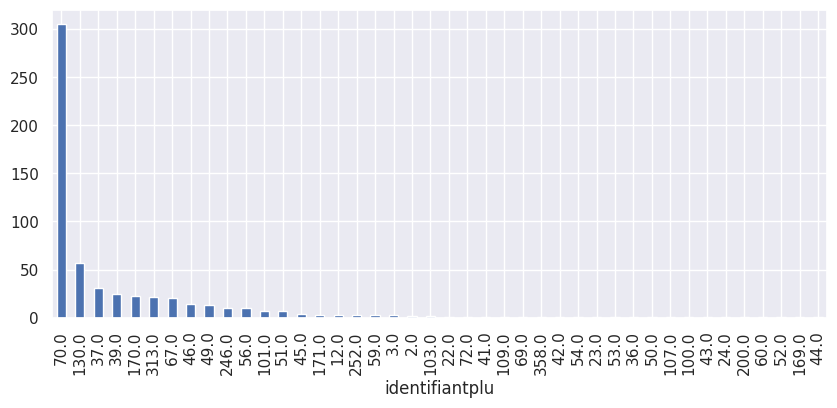

In [17]:
# @title `identifiantplu`
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()

df_clean.identifiantplu.value_counts().plot.bar(ax=ax)

plt.show()

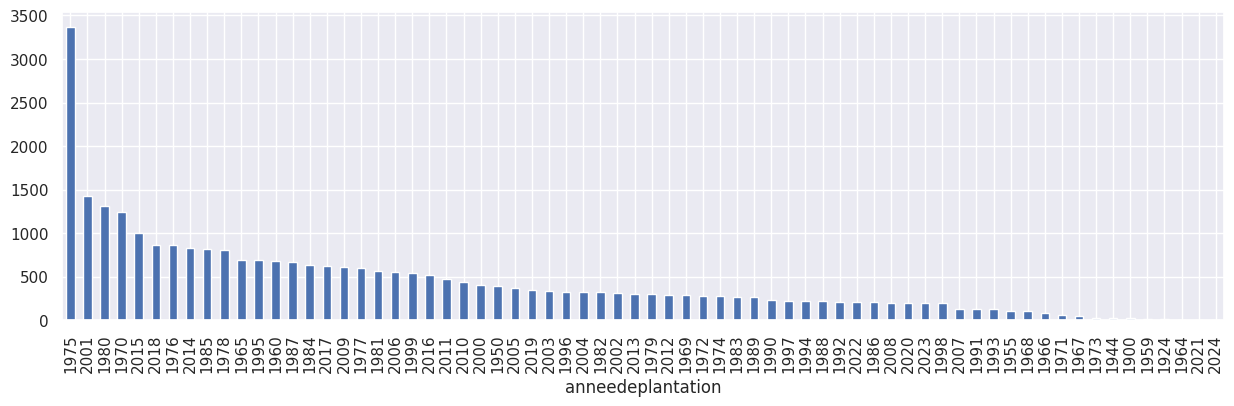

In [18]:
# @title `anneedeplantation`
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot()

df_clean.anneedeplantation.value_counts().plot.bar(ax=ax)

plt.show()

In [20]:
m = folium.Map(location=[df_clean.latitude.mean(), df_clean.longitude.mean()])

from folium.plugins import HeatMap

HeatMap(df_clean[["latitude", "longitude"]].dropna().values).add_to(m)

m

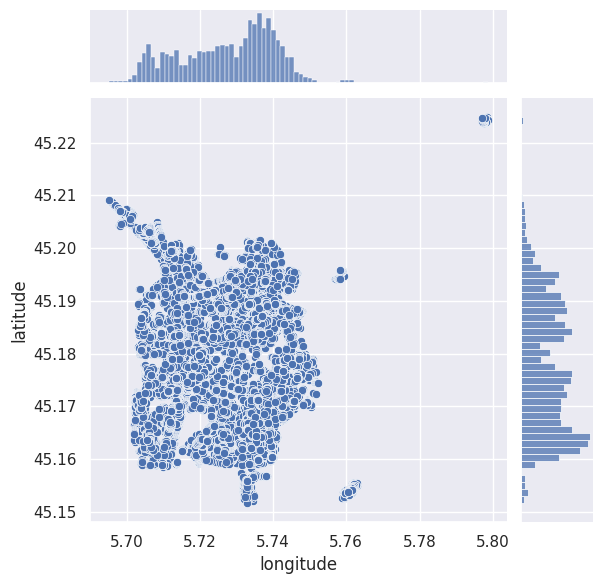

In [21]:
sns.jointplot(data=df_clean, x="longitude", y="latitude")

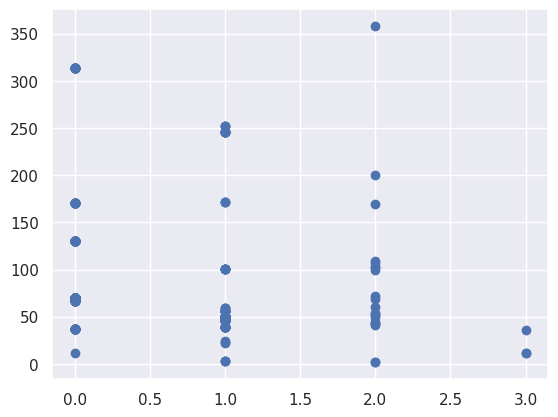

In [22]:
# @title typeimplantationplu and identifiantplu
from sklearn.preprocessing import OrdinalEncoder

plt.scatter(x=OrdinalEncoder().fit_transform(df_clean[["typeimplantationplu"]]), y=df_clean["identifiantplu"])

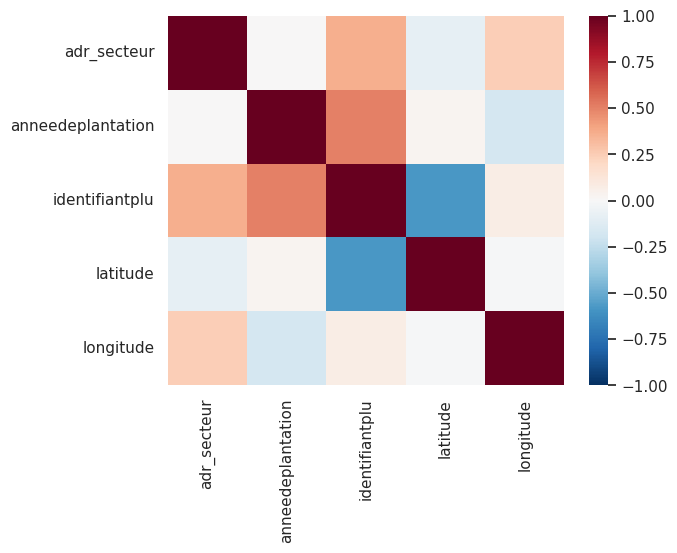

In [23]:
# @title Correlation

corr_matrix = df_clean.select_dtypes("number").corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="RdBu_r")

plt.show()